In [29]:
import torch
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, Subset
from utils.data import COCOAEDataset, collate_fn
from utils.transforms import get_transform
from utils.transforms import ResizeTransform
from noise.scheduler import NoiseScheduler, LinearMaskScheduler, mask_image
from models.masked_autoencoder import MaskedAEConfig, MaskedAutoEncoderForPretraining, MaskedAutoEncoderForCaptioning, MaskedAutoEncoder
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
original_dataset = COCOAEDataset(root="coco/images/train2017/",
                        annFile="coco/annotations/ann2017/captions_train2017.json",
                        transform=get_transform(),
                        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased', cache_dir='cache/'),
                        ignore_cache=False,
                        train=True)


Loading cached annotations...


In [3]:
dataset = Subset(original_dataset, range(4))

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=True,
                        collate_fn=collate_fn(dataset.dataset.tokenizer.pad_token_id),
                        pin_memory=True)


noise_scheduler = LinearMaskScheduler(vocab_size=len(dataset.dataset.tokenizer), masking_ratio=0.0)
# model = MaskedAutoEncoderForPretraining(MaskedAEConfig(len(dataset.tokenizer))).to(DEVICE)
# model = CaptionGenerator(MaskedAEConfig(len(dataset.tokenizer))).to(DEVICE)


In [30]:
config = MaskedAEConfig(len(dataset.dataset.tokenizer))
pretrained = MaskedAutoEncoder(config).to(DEVICE)
checkpoint = torch.load("checkpoints/base_0",map_location=torch.device('cpu'))
pretrained.load_state_dict(checkpoint)

<All keys matched successfully>

In [33]:
model = MaskedAutoEncoderForCaptioning(MaskedAEConfig(len(dataset.dataset.tokenizer)), pretrained=pretrained).to(DEVICE)

In [34]:
optim = torch.optim.Adam(model.parameters(), lr=4e-5)
optim = torch.optim.AdamW(model.parameters(), lr=1.5e-4, betas=(0.9, 0.95), weight_decay=0.03)

image_loss = torch.nn.MSELoss()
caption_loss = torch.nn.CrossEntropyLoss()
caption_loss = torch.nn.MSELoss()

In [88]:
testimg, testcap = original_dataset[10]
for c in testcap:
    print(dataset.dataset.tokenizer.decode(c))

dark cluttered storage area wood walls
[unused6]


In [36]:
for epoch in (pbar := tqdm(range(500))):
    for images, captions, lengths in dataloader:
        optim.zero_grad()
        images = images.to(DEVICE, non_blocking=True)
        captions = captions.to(DEVICE, non_blocking=True)

        masked_images, masked_text, targets, (image_positions, rp) = noise_scheduler.get_masked(images, captions, lengths, need_masks=True)
        # print(masked_images.shape, masked_text.shape)        
        reconstructed_captions = model.forward(masked_images, image_positions)
        if epoch % 5 == 0:
            for c in captions:
                print("Original:", dataset.dataset.tokenizer.decode(c))
            for caption in reconstructed_captions:
                # print(caption.shape)
                values, indices = torch.topk(caption, 10)
                # print(values, indices)
                for i in indices:
                    print(dataset.dataset.tokenizer.decode(i), end = ", ")      
                print("")                      
            for c in reconstructed_captions:
                print("Generated:", dataset.dataset.tokenizer.decode(torch.argmax(c, dim=-1)))            
        # print(captions, reconstructed_captions)
        if epoch == 499:
            print(captions, reconstructed_captions)
        
        padded_caption = torch.nn.functional.pad(captions, (0, 10-captions.shape[1]))
        # print(reconstructed_captions.shape, targets.shape)
        cap_loss = caption_loss(reconstructed_captions, targets)
        # cap_loss = caption_loss(reconstructed_captions.permute(0, 2, 1), padded_caption)
        pbar.set_description(f"Epoch: {epoch}, Caption Loss : {cap_loss.item():1.3}")
        cap_loss.backward()
        # print(model.ite.weight.grad)
        optim.step()
        
    


Epoch: 0, Caption Loss : 0.000246:   0%|          | 0/500 [00:03<?, ?it/s]

Original: woman marking cake back chef knife [PAD] [PAD] [PAD]
Original: child holding flowered umbrella petting yak
Generated: morse
Generated: blankly


Epoch: 0, Caption Loss : 0.000459:   0%|          | 0/500 [00:13<?, ?it/s]

Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Original: little boy wearing headphones looking computer monitor [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: together
Generated: morse


Epoch: 5, Caption Loss : 0.000213:   1%|          | 5/500 [01:00<1:29:46, 10.88s/it]

Original: young boy umbrella is touching horn cow
Original: woman cutting large white sheet cake [PAD]
Generated: eki
Generated: restricted


Epoch: 5, Caption Loss : 0.000197:   1%|          | 5/500 [01:04<1:29:46, 10.88s/it]

Original: man red shirt red hat is motorcycle hill side
Original: is listening computer school [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: together
Generated: tq


Epoch: 10, Caption Loss : 0.000262:   2%|▏         | 10/500 [01:49<1:25:14, 10.44s/it]

Original: woman wearing hair net cutting large sheet cake
Original: little boy wearing headphones looking computer monitor
Generated: restricted
Generated: tq


Epoch: 10, Caption Loss : 0.000262:   2%|▏         | 10/500 [01:54<1:25:14, 10.44s/it]

Original: young boy barefoot holding umbrella touching horn cow
Original: man red helmet small moped dirt road
Generated: curves
Generated: together


Epoch: 15, Caption Loss : 0.000164:   3%|▎         | 15/500 [02:34<1:13:28,  9.09s/it]

Original: woman wearing net head cutting cake
Original: is listening computer school [PAD] [PAD]
Generated: assemblies
Generated: senator


Epoch: 15, Caption Loss : 0.000442:   3%|▎         | 15/500 [02:38<1:13:28,  9.09s/it]

Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Original: young boy umbrella is touching horn cow [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: together
Generated: blankly


Epoch: 20, Caption Loss : 0.000442:   4%|▍         | 20/500 [03:19<1:11:36,  8.95s/it]

Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Original: young boy umbrella is touching horn cow [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: together
Generated: together


Epoch: 20, Caption Loss : 0.000197:   4%|▍         | 20/500 [03:23<1:11:36,  8.95s/it]

Original: woman marking cake back chef knife
Original: young kid head phones using computer
Generated: restricted
Generated: blankly


Epoch: 25, Caption Loss : 0.000197:   5%|▌         | 25/500 [04:06<1:12:44,  9.19s/it]

Original: young boy standing front computer keyboard
Original: woman marking cake back chef knife
Generated: tq
Generated: restricted


Epoch: 25, Caption Loss : 0.000246:   5%|▌         | 25/500 [04:11<1:12:44,  9.19s/it]

Original: man red shirt red hat is motorcycle hill side
Original: young boy umbrella is touching horn cow [PAD] [PAD]
Generated: together
Generated: together


Epoch: 30, Caption Loss : 0.000213:   6%|▌         | 30/500 [04:51<1:10:47,  9.04s/it]

Original: man riding motor bike dirt road countryside
Original: young kid head phones using computer [PAD]
Generated: together
Generated: tq


Epoch: 30, Caption Loss : 0.000213:   6%|▌         | 30/500 [04:57<1:10:47,  9.04s/it]

Original: young boy umbrella is touching horn cow
Original: woman marking cake back chef knife [PAD]
Generated: 332
Generated: restricted


Epoch: 35, Caption Loss : 0.000246:   7%|▋         | 35/500 [05:48<1:19:27, 10.25s/it]

Original: child holding flowered umbrella petting yak
Original: woman cutting large white sheet cake [PAD] [PAD] [PAD]
Generated: midi
Generated: restricted


Epoch: 35, Caption Loss : 0.000229:   7%|▋         | 35/500 [05:53<1:19:27, 10.25s/it]

Original: young boy standing front computer keyboard [PAD] [PAD]
Original: man red helmet small moped dirt road
Generated: ᅲ
Generated: together


Epoch: 40, Caption Loss : 0.000213:   8%|▊         | 40/500 [06:34<1:11:27,  9.32s/it]

Original: young kid head phones using computer [PAD]
Original: young boy umbrella is touching horn cow
Generated: tq
Generated: jefferson


Epoch: 40, Caption Loss : 0.000213:   8%|▊         | 40/500 [06:39<1:11:27,  9.32s/it]

Original: woman wearing net head cutting cake [PAD]
Original: man riding motor bike dirt road countryside
Generated: restricted
Generated: together


Epoch: 45, Caption Loss : 0.000246:   9%|▉         | 45/500 [07:27<1:18:35, 10.36s/it]

Original: young boy umbrella is touching horn cow [PAD]
Original: little boy wearing headphones looking computer monitor
Generated: voters
Generated: ##itive


Epoch: 45, Caption Loss : 0.000262:   9%|▉         | 45/500 [07:31<1:18:35, 10.36s/it]

Original: woman wearing hair net cutting large sheet cake
Original: man red helmet small moped dirt road
Generated: restricted
Generated: together


Epoch: 50, Caption Loss : 0.000213:  10%|█         | 50/500 [08:10<1:07:01,  8.94s/it]

Original: boy holding umbrella standing next livestock [PAD]
Original: man riding motor bike dirt road countryside
Generated: stone
Generated: together


Epoch: 50, Caption Loss : 0.000164:  10%|█         | 50/500 [08:14<1:07:01,  8.94s/it]

Original: woman cutting large white sheet cake
Original: is listening computer school [PAD] [PAD]
Generated: restricted
Generated: baronetcy


Epoch: 55, Caption Loss : 0.000229:  11%|█         | 55/500 [08:52<1:02:54,  8.48s/it]

Original: young kid head phones using computer [PAD] [PAD]
Original: man red helmet small moped dirt road
Generated: trier
Generated: together


Epoch: 55, Caption Loss : 0.000197:  11%|█         | 55/500 [08:56<1:02:54,  8.48s/it]

Original: boy holding umbrella standing next livestock
Original: woman marking cake back chef knife
Generated: codex
Generated: restricted


Epoch: 60, Caption Loss : 0.000213:  12%|█▏        | 60/500 [09:47<1:14:20, 10.14s/it]

Original: young kid head phones using computer [PAD]
Original: young man holding umbrella next herd cattle
Generated: ##horpe
Generated: boy


Epoch: 60, Caption Loss : 0.000147:  12%|█▏        | 60/500 [09:51<1:14:20, 10.14s/it]

Original: is woman is cutting white cake
Original: man riding back motorcycle [PAD] [PAD]
Generated: restricted
Generated: together


Epoch: 65, Caption Loss : 0.000213:  13%|█▎        | 65/500 [10:29<1:05:19,  9.01s/it]

Original: child holding flowered umbrella petting yak
Original: is listening computer school [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: boy
Generated: boy


Epoch: 65, Caption Loss : 0.000164:  13%|█▎        | 65/500 [10:33<1:05:19,  9.01s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: woman cutting large white sheet cake
Generated: imported
Generated: cake


Epoch: 70, Caption Loss : 0.000197:  14%|█▍        | 70/500 [11:13<1:04:51,  9.05s/it]

Original: woman marking cake back chef knife
Original: young kid head phones using computer
Generated: cake
Generated: boy


Epoch: 70, Caption Loss : 0.000197:  14%|█▍        | 70/500 [11:18<1:04:51,  9.05s/it]

Original: young boy barefoot holding umbrella touching horn cow
Original: man riding back motorcycle [PAD] [PAD] [PAD] [PAD]
Generated: boy
Generated: umbrella


Epoch: 75, Caption Loss : 0.000213:  15%|█▌        | 75/500 [11:54<58:17,  8.23s/it]  

Original: young man holding umbrella next herd cattle
Original: young kid head phones using computer [PAD]
Generated: boy
Generated: boy


Epoch: 75, Caption Loss : 0.000229:  15%|█▌        | 75/500 [11:58<58:17,  8.23s/it]

Original: man red shirt red hat is motorcycle hill side
Original: woman marking cake back chef knife [PAD] [PAD] [PAD]
Generated: umbrella
Generated: cake


Epoch: 80, Caption Loss : 0.000229:  16%|█▌        | 80/500 [12:34<56:29,  8.07s/it]

Original: woman wearing net head cutting cake [PAD] [PAD] [PAD]
Original: man red shirt red hat is motorcycle hill side
Generated: cake
Generated: umbrella


Epoch: 80, Caption Loss : 0.000197:  16%|█▌        | 80/500 [12:39<56:29,  8.07s/it]

Original: young kid head phones using computer
Original: boy holding umbrella standing next livestock
Generated: boy
Generated: umbrella


Epoch: 85, Caption Loss : 0.00018:  17%|█▋        | 85/500 [13:17<58:22,  8.44s/it] 

Original: young boy stares computer monitor [PAD]
Original: boy holding umbrella standing next livestock
Generated: boy
Generated: umbrella


Epoch: 85, Caption Loss : 0.000147:  17%|█▋        | 85/500 [13:21<58:22,  8.44s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: is woman is cutting white cake
Generated: umbrella
Generated: cake


Epoch: 90, Caption Loss : 0.000197:  18%|█▊        | 90/500 [13:57<54:24,  7.96s/it]

Original: woman wearing net head cutting cake
Original: young boy standing front computer keyboard
Generated: cake
Generated: boy


Epoch: 90, Caption Loss : 0.000459:  18%|█▊        | 90/500 [14:01<54:24,  7.96s/it]

Original: young boy barefoot holding umbrella touching horn cow [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: umbrella
Generated: umbrella


Epoch: 95, Caption Loss : 0.000164:  19%|█▉        | 95/500 [14:42<59:36,  8.83s/it]

Original: young kid head phones using computer
Original: man riding back motorcycle [PAD] [PAD]
Generated: boy
Generated: umbrella


Epoch: 95, Caption Loss : 0.000246:  19%|█▉        | 95/500 [14:46<59:36,  8.83s/it]

Original: woman wearing hair net cutting large sheet cake
Original: young boy umbrella is touching horn cow [PAD]
Generated: cake
Generated: umbrella


Epoch: 100, Caption Loss : 0.000459:  20%|██        | 100/500 [15:24<57:05,  8.56s/it]

Original: woman wearing hair net cutting large sheet cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: umbrella


Epoch: 100, Caption Loss : 0.000213:  20%|██        | 100/500 [15:28<57:05,  8.56s/it]

Original: young kid head phones using computer [PAD]
Original: young boy umbrella is touching horn cow
Generated: boy
Generated: umbrella


Epoch: 105, Caption Loss : 0.000213:  21%|██        | 105/500 [16:04<53:23,  8.11s/it]

Original: young kid head phones using computer [PAD]
Original: young man holding umbrella next herd cattle
Generated: boy
Generated: umbrella


Epoch: 105, Caption Loss : 0.000147:  21%|██        | 105/500 [16:08<53:23,  8.11s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: is woman is cutting white cake
Generated: umbrella
Generated: cake


Epoch: 110, Caption Loss : 0.000229:  22%|██▏       | 110/500 [16:44<52:58,  8.15s/it]

Original: man riding motor bike dirt road countryside
Original: young man holding umbrella next herd cattle
Generated: umbrella
Generated: umbrella


Epoch: 110, Caption Loss : 0.000213:  22%|██▏       | 110/500 [16:48<52:58,  8.15s/it]

Original: little boy wearing headphones looking computer monitor
Original: is woman is cutting white cake [PAD] [PAD]
Generated: boy
Generated: cake


Epoch: 115, Caption Loss : 0.000196:  23%|██▎       | 115/500 [17:23<49:07,  7.66s/it]

Original: young boy barefoot holding umbrella touching horn cow
Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Generated: umbrella
Generated: cake


Epoch: 115, Caption Loss : 0.000426:  23%|██▎       | 115/500 [17:27<49:07,  7.66s/it]

Original: woman cutting large white sheet cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: umbrella


Epoch: 120, Caption Loss : 0.000426:  24%|██▍       | 120/500 [18:02<50:04,  7.91s/it]

Original: young kid head phones using computer [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: umbrella


Epoch: 120, Caption Loss : 0.000244:  24%|██▍       | 120/500 [18:06<50:04,  7.91s/it]

Original: child holding flowered umbrella petting yak
Original: woman cutting large white sheet cake [PAD] [PAD] [PAD]
Generated: umbrella
Generated: cake


Epoch: 125, Caption Loss : 0.000245:  25%|██▌       | 125/500 [18:42<48:46,  7.80s/it]

Original: man red shirt red hat is motorcycle hill side
Original: young boy umbrella is touching horn cow [PAD] [PAD]
Generated: cake
Generated: cake


Epoch: 125, Caption Loss : 0.000184:  25%|██▌       | 125/500 [18:45<48:46,  7.80s/it]

Original: young kid head phones using computer
Original: woman wearing net head cutting cake
Generated: cake
Generated: cake


Epoch: 130, Caption Loss : 0.000183:  26%|██▌       | 130/500 [19:20<47:55,  7.77s/it]

Original: young man holding umbrella next herd cattle
Original: woman marking cake back chef knife [PAD]
Generated: umbrella
Generated: cake


Epoch: 130, Caption Loss : 0.000231:  26%|██▌       | 130/500 [19:25<47:55,  7.77s/it]

Original: man red shirt red hat is motorcycle hill side
Original: young boy standing front computer keyboard [PAD] [PAD] [PAD]
Generated: umbrella
Generated: umbrella


Epoch: 135, Caption Loss : 0.000229:  27%|██▋       | 135/500 [20:03<50:10,  8.25s/it]

Original: little boy wearing headphones looking computer monitor
Original: young man holding umbrella next herd cattle [PAD]
Generated: umbrella
Generated: umbrella


Epoch: 135, Caption Loss : 0.000197:  27%|██▋       | 135/500 [20:07<50:10,  8.25s/it]

Original: man red shirt red hat is motorcycle hill side
Original: is woman is cutting white cake [PAD] [PAD] [PAD]
Generated: umbrella
Generated: cake


Epoch: 140, Caption Loss : 0.00018:  28%|██▊       | 140/500 [20:42<47:35,  7.93s/it] 

Original: young boy barefoot holding umbrella touching horn cow
Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Generated: umbrella
Generated: umbrella


Epoch: 140, Caption Loss : 0.000147:  28%|██▊       | 140/500 [20:46<47:35,  7.93s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: woman cutting large white sheet cake
Generated: umbrella
Generated: cake


Epoch: 145, Caption Loss : 0.000246:  29%|██▉       | 145/500 [21:24<49:24,  8.35s/it]

Original: man red helmet small moped dirt road
Original: woman wearing hair net cutting large sheet cake
Generated: umbrella
Generated: cake


Epoch: 145, Caption Loss : 0.00018:  29%|██▉       | 145/500 [21:28<49:24,  8.35s/it] 

Original: young boy standing front computer keyboard
Original: boy holding umbrella standing next livestock
Generated: umbrella
Generated: umbrella


Epoch: 150, Caption Loss : 0.000262:  30%|███       | 150/500 [22:04<47:08,  8.08s/it]

Original: little boy wearing headphones looking computer monitor [PAD]
Original: man red shirt red hat is motorcycle hill side
Generated: umbrella
Generated: umbrella


Epoch: 150, Caption Loss : 0.000147:  30%|███       | 150/500 [22:08<47:08,  8.08s/it]

Original: is woman is cutting white cake
Original: boy holding umbrella standing next livestock
Generated: cake
Generated: umbrella


Epoch: 155, Caption Loss : 0.000213:  31%|███       | 155/500 [22:43<45:24,  7.90s/it]

Original: young man holding umbrella next herd cattle
Original: man riding motor bike dirt road countryside
Generated: umbrella
Generated: umbrella


Epoch: 155, Caption Loss : 0.000158:  31%|███       | 155/500 [22:47<45:24,  7.90s/it]

Original: young boy stares computer monitor [PAD]
Original: woman wearing net head cutting cake
Generated: boy
Generated: cake


Epoch: 160, Caption Loss : 0.000148:  32%|███▏      | 160/500 [23:27<51:36,  9.11s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: woman marking cake back chef knife
Generated: umbrella
Generated: cake


Epoch: 160, Caption Loss : 0.000189:  32%|███▏      | 160/500 [23:31<51:36,  9.11s/it]

Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Original: young boy barefoot holding umbrella touching horn cow
Generated: boy
Generated: umbrella


Epoch: 165, Caption Loss : 0.000199:  33%|███▎      | 165/500 [24:13<49:16,  8.82s/it]

Original: woman wearing net head cutting cake [PAD]
Original: man riding motor bike dirt road countryside
Generated: cake
Generated: umbrella


Epoch: 165, Caption Loss : 0.000185:  33%|███▎      | 165/500 [24:17<49:16,  8.82s/it]

Original: boy holding umbrella standing next livestock
Original: young boy standing front computer keyboard
Generated: umbrella
Generated: umbrella


Epoch: 170, Caption Loss : 0.000214:  34%|███▍      | 170/500 [24:53<44:31,  8.10s/it]

Original: man riding motor bike dirt road countryside
Original: young man holding umbrella next herd cattle
Generated: arthritis
Generated: umbrella


Epoch: 170, Caption Loss : 0.000164:  34%|███▍      | 170/500 [24:56<44:31,  8.10s/it]

Original: young boy standing front computer keyboard
Original: woman marking cake back chef knife
Generated: boy
Generated: cake


Epoch: 175, Caption Loss : 0.000197:  35%|███▌      | 175/500 [25:32<42:09,  7.78s/it]

Original: woman cutting large white sheet cake [PAD] [PAD]
Original: young boy barefoot holding umbrella touching horn cow
Generated: cake
Generated: boy


Epoch: 175, Caption Loss : 0.000407:  35%|███▌      | 175/500 [25:35<42:09,  7.78s/it]

Original: young boy stares computer monitor [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: boy
Generated: boy


Epoch: 180, Caption Loss : 0.000197:  36%|███▌      | 180/500 [26:09<40:42,  7.63s/it]

Original: is woman is cutting white cake [PAD] [PAD]
Original: man red helmet small moped dirt road
Generated: cake
Generated: cake


Epoch: 180, Caption Loss : 0.000229:  36%|███▌      | 180/500 [26:13<40:42,  7.63s/it]

Original: little boy wearing headphones looking computer monitor
Original: boy holding umbrella standing next livestock [PAD] [PAD]
Generated: cake
Generated: cake


Epoch: 185, Caption Loss : 0.00018:  37%|███▋      | 185/500 [26:51<43:22,  8.26s/it] 

Original: is listening computer school [PAD] [PAD] [PAD]
Original: man riding motor bike dirt road countryside
Generated: boy
Generated: boy


Epoch: 185, Caption Loss : 0.000197:  37%|███▋      | 185/500 [26:56<43:22,  8.26s/it]

Original: woman cutting large white sheet cake [PAD]
Original: young boy umbrella is touching horn cow
Generated: cake
Generated: boy


Epoch: 190, Caption Loss : 0.000262:  38%|███▊      | 190/500 [27:32<42:29,  8.22s/it]

Original: man red helmet small moped dirt road
Original: little boy wearing headphones looking computer monitor
Generated: boy
Generated: boy


Epoch: 190, Caption Loss : 0.00018:  38%|███▊      | 190/500 [27:36<42:29,  8.22s/it] 

Original: young man holding umbrella next herd cattle
Original: is woman is cutting white cake [PAD]
Generated: boy
Generated: cake


Epoch: 195, Caption Loss : 0.00018:  39%|███▉      | 195/500 [28:13<40:47,  8.02s/it] 

Original: young man holding umbrella next herd cattle
Original: is listening computer school [PAD] [PAD] [PAD]
Generated: boy
Generated: boy


Epoch: 195, Caption Loss : 0.00041:  39%|███▉      | 195/500 [28:17<40:47,  8.02s/it]

Original: woman wearing net head cutting cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: boy


Epoch: 200, Caption Loss : 0.000197:  40%|████      | 200/500 [28:53<40:29,  8.10s/it]

Original: woman wearing net head cutting cake [PAD]
Original: young boy umbrella is touching horn cow
Generated: cake
Generated: boy


Epoch: 200, Caption Loss : 0.000229:  40%|████      | 200/500 [28:57<40:29,  8.10s/it]

Original: young boy standing front computer keyboard [PAD] [PAD]
Original: man red helmet small moped dirt road
Generated: boy
Generated: boy


Epoch: 205, Caption Loss : 0.000229:  41%|████      | 205/500 [29:33<39:54,  8.12s/it]

Original: young kid head phones using computer [PAD] [PAD] [PAD]
Original: man red shirt red hat is motorcycle hill side
Generated: cake
Generated: cake


Epoch: 205, Caption Loss : 0.000196:  41%|████      | 205/500 [29:37<39:54,  8.12s/it]

Original: young boy barefoot holding umbrella touching horn cow
Original: is woman is cutting white cake [PAD] [PAD]
Generated: boy
Generated: cake


Epoch: 210, Caption Loss : 0.000197:  42%|████▏     | 210/500 [30:11<37:55,  7.85s/it]

Original: woman marking cake back chef knife [PAD]
Original: man riding motor bike dirt road countryside
Generated: cake
Generated: boy


Epoch: 210, Caption Loss : 0.000211:  42%|████▏     | 210/500 [30:15<37:55,  7.85s/it]

Original: young kid head phones using computer [PAD]
Original: young boy umbrella is touching horn cow
Generated: cake
Generated: boy


Epoch: 215, Caption Loss : 0.000182:  43%|████▎     | 215/500 [30:50<36:34,  7.70s/it]

Original: is woman is cutting white cake [PAD] [PAD]
Original: young boy barefoot holding umbrella touching horn cow
Generated: cake
Generated: boy


Epoch: 215, Caption Loss : 0.00022:  43%|████▎     | 215/500 [30:54<36:34,  7.70s/it] 

Original: man red shirt red hat is motorcycle hill side
Original: young boy standing front computer keyboard [PAD] [PAD] [PAD]
Generated: boy
Generated: boy


Epoch: 220, Caption Loss : 0.000159:  44%|████▍     | 220/500 [31:28<35:23,  7.59s/it]

Original: is listening computer school [PAD] [PAD]
Original: woman cutting large white sheet cake
Generated: boy
Generated: cake


Epoch: 220, Caption Loss : 0.000432:  44%|████▍     | 220/500 [31:32<35:23,  7.59s/it]

Original: young boy umbrella is touching horn cow [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: boy
Generated: boy


Epoch: 225, Caption Loss : 0.000206:  45%|████▌     | 225/500 [32:08<36:06,  7.88s/it]

Original: young boy standing front computer keyboard [PAD]
Original: man riding motor bike dirt road countryside
Generated: boy
Generated: boy


Epoch: 225, Caption Loss : 0.000197:  45%|████▌     | 225/500 [32:12<36:06,  7.88s/it]

Original: woman marking cake back chef knife [PAD]
Original: young man holding umbrella next herd cattle
Generated: cake
Generated: boy


Epoch: 230, Caption Loss : 0.000206:  46%|████▌     | 230/500 [32:47<35:11,  7.82s/it]

Original: young kid head phones using computer [PAD]
Original: young boy umbrella is touching horn cow
Generated: boy
Generated: boy


Epoch: 230, Caption Loss : 0.000197:  46%|████▌     | 230/500 [32:51<35:11,  7.82s/it]

Original: man riding motor bike dirt road countryside
Original: woman wearing net head cutting cake [PAD]
Generated: boy
Generated: cake


Epoch: 235, Caption Loss : 0.000214:  47%|████▋     | 235/500 [33:30<37:34,  8.51s/it]

Original: young boy umbrella is touching horn cow [PAD]
Original: little boy wearing headphones looking computer monitor
Generated: boy
Generated: boy


Epoch: 235, Caption Loss : 0.000199:  47%|████▋     | 235/500 [33:35<37:34,  8.51s/it]

Original: man riding motor bike dirt road countryside
Original: woman wearing net head cutting cake [PAD]
Generated: boy
Generated: cake


Epoch: 240, Caption Loss : 0.00018:  48%|████▊     | 240/500 [34:15<39:28,  9.11s/it] 

Original: is woman is cutting white cake [PAD]
Original: young man holding umbrella next herd cattle
Generated: cake
Generated: boy


Epoch: 240, Caption Loss : 0.00019:  48%|████▊     | 240/500 [34:19<39:28,  9.11s/it]

Original: young boy stares computer monitor [PAD] [PAD]
Original: man riding motor bike dirt road countryside
Generated: boy
Generated: boy


Epoch: 245, Caption Loss : 0.000132:  49%|████▉     | 245/500 [34:59<38:00,  8.94s/it]

Original: is woman is cutting white cake
Original: man riding back motorcycle [PAD] [PAD]
Generated: cake
Generated: young


Epoch: 245, Caption Loss : 0.00017:  49%|████▉     | 245/500 [35:03<38:00,  8.94s/it] 

Original: young boy standing front computer keyboard [PAD]
Original: young boy umbrella is touching horn cow
Generated: young
Generated: young


Epoch: 250, Caption Loss : 0.000229:  50%|█████     | 250/500 [35:43<36:02,  8.65s/it]

Original: young boy standing front computer keyboard [PAD] [PAD] [PAD]
Original: child holding flowered umbrella petting yak
Generated: young
Generated: young


Epoch: 250, Caption Loss : 0.000237:  50%|█████     | 250/500 [35:46<36:02,  8.65s/it]

Original: man riding motor bike dirt road countryside [PAD]
Original: woman wearing hair net cutting large sheet cake
Generated: young
Generated: cake


Epoch: 255, Caption Loss : 0.000211:  51%|█████     | 255/500 [36:26<34:39,  8.49s/it]

Original: man red helmet small moped dirt road
Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Generated: young
Generated: young


Epoch: 255, Caption Loss : 0.000208:  51%|█████     | 255/500 [36:30<34:39,  8.49s/it]

Original: woman wearing hair net cutting large sheet cake
Original: boy holding umbrella standing next livestock [PAD] [PAD]
Generated: cake
Generated: young


Epoch: 260, Caption Loss : 0.000182:  52%|█████▏    | 260/500 [37:07<32:18,  8.08s/it]

Original: young man holding umbrella next herd cattle
Original: young kid head phones using computer [PAD]
Generated: young
Generated: young


Epoch: 260, Caption Loss : 0.000393:  52%|█████▏    | 260/500 [37:10<32:18,  8.08s/it]

Original: woman marking cake back chef knife [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: young


Epoch: 265, Caption Loss : 0.000213:  53%|█████▎    | 265/500 [37:44<29:50,  7.62s/it]

Original: man red helmet small moped dirt road
Original: young kid head phones using computer [PAD] [PAD]
Generated: young
Generated: young


Epoch: 265, Caption Loss : 0.000229:  53%|█████▎    | 265/500 [37:48<29:50,  7.62s/it]

Original: woman wearing hair net cutting large sheet cake
Original: young boy barefoot holding umbrella touching horn cow
Generated: cake
Generated: young


Epoch: 270, Caption Loss : 0.000163:  54%|█████▍    | 270/500 [38:25<30:10,  7.87s/it]

Original: young boy standing front computer keyboard
Original: woman marking cake back chef knife
Generated: young
Generated: cake


Epoch: 270, Caption Loss : 0.000237:  54%|█████▍    | 270/500 [38:29<30:10,  7.87s/it]

Original: young man holding umbrella next herd cattle [PAD]
Original: man red helmet small moped dirt road
Generated: young
Generated: rightful


Epoch: 275, Caption Loss : 0.000239:  55%|█████▌    | 275/500 [39:04<29:18,  7.81s/it]

Original: man red shirt red hat is motorcycle hill side
Original: young man holding umbrella next herd cattle [PAD] [PAD]
Generated: young
Generated: boy


Epoch: 275, Caption Loss : 0.00014:  55%|█████▌    | 275/500 [39:08<29:18,  7.81s/it] 

Original: is listening computer school [PAD] [PAD]
Original: is woman is cutting white cake
Generated: young
Generated: cake


Epoch: 280, Caption Loss : 0.000409:  56%|█████▌    | 280/500 [39:46<30:00,  8.19s/it]

Original: woman marking cake back chef knife [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: boy


Epoch: 280, Caption Loss : 0.000228:  56%|█████▌    | 280/500 [39:52<30:00,  8.19s/it]

Original: child holding flowered umbrella petting yak
Original: is listening computer school [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: boy
Generated: boy


Epoch: 285, Caption Loss : 0.00019:  57%|█████▋    | 285/500 [40:32<30:00,  8.38s/it] 

Original: woman wearing hair net cutting large sheet cake
Original: young boy standing front computer keyboard [PAD] [PAD]
Generated: cake
Generated: young


Epoch: 285, Caption Loss : 0.000157:  57%|█████▋    | 285/500 [40:36<30:00,  8.38s/it]

Original: young boy umbrella is touching horn cow
Original: man riding back motorcycle [PAD] [PAD] [PAD]
Generated: young
Generated: young


Epoch: 290, Caption Loss : 0.000209:  58%|█████▊    | 290/500 [41:14<29:43,  8.49s/it]

Original: boy holding umbrella standing next livestock [PAD] [PAD]
Original: little boy wearing headphones looking computer monitor
Generated: boy
Generated: boy


Epoch: 290, Caption Loss : 0.000442:  58%|█████▊    | 290/500 [41:18<29:43,  8.49s/it]

Original: woman wearing hair net cutting large sheet cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: ##χ


Epoch: 295, Caption Loss : 0.000211:  59%|█████▉    | 295/500 [41:52<26:20,  7.71s/it]

Original: boy holding umbrella standing next livestock [PAD] [PAD]
Original: woman wearing hair net cutting large sheet cake
Generated: young
Generated: cake


Epoch: 295, Caption Loss : 0.000205:  59%|█████▉    | 295/500 [41:56<26:20,  7.71s/it]

Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Original: man red helmet small moped dirt road
Generated: young
Generated: ##ང


Epoch: 300, Caption Loss : 0.000199:  60%|██████    | 300/500 [42:33<26:55,  8.08s/it]

Original: young man holding umbrella next herd cattle
Original: woman wearing net head cutting cake [PAD]
Generated: boy
Generated: cake


Epoch: 300, Caption Loss : 0.000405:  60%|██████    | 300/500 [42:38<26:55,  8.08s/it]

Original: young boy standing front computer keyboard [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: boy
Generated: statues


Epoch: 305, Caption Loss : 0.00019:  61%|██████    | 305/500 [43:18<29:18,  9.02s/it] 

Original: young man holding umbrella next herd cattle
Original: young kid head phones using computer [PAD]
Generated: young
Generated: young


Epoch: 305, Caption Loss : 0.000197:  61%|██████    | 305/500 [43:22<29:18,  9.02s/it]

Original: man riding motor bike dirt road countryside
Original: woman cutting large white sheet cake [PAD]
Generated: joint
Generated: cake


Epoch: 310, Caption Loss : 0.00041:  62%|██████▏   | 310/500 [43:59<26:33,  8.39s/it] 

Original: woman wearing net head cutting cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: young


Epoch: 310, Caption Loss : 0.000183:  62%|██████▏   | 310/500 [44:03<26:33,  8.39s/it]

Original: young boy barefoot holding umbrella touching horn cow
Original: young boy standing front computer keyboard [PAD] [PAD]
Generated: young
Generated: young


Epoch: 315, Caption Loss : 0.000173:  63%|██████▎   | 315/500 [44:44<28:56,  9.38s/it]

Original: young boy umbrella is touching horn cow
Original: woman wearing net head cutting cake [PAD]
Generated: boy
Generated: cake


Epoch: 315, Caption Loss : 0.000172:  63%|██████▎   | 315/500 [44:49<28:56,  9.38s/it]

Original: young boy stares computer monitor [PAD] [PAD]
Original: man riding motor bike dirt road countryside
Generated: young
Generated: young


Epoch: 320, Caption Loss : 0.000166:  64%|██████▍   | 320/500 [45:29<27:05,  9.03s/it]

Original: is listening computer school [PAD] [PAD]
Original: boy holding umbrella standing next livestock
Generated: young
Generated: young


Epoch: 320, Caption Loss : 0.000197:  64%|██████▍   | 320/500 [45:33<27:05,  9.03s/it]

Original: man riding motor bike dirt road countryside
Original: woman cutting large white sheet cake [PAD]
Generated: young
Generated: cake


Epoch: 325, Caption Loss : 0.000164:  65%|██████▌   | 325/500 [46:14<28:29,  9.77s/it]

Original: young boy standing front computer keyboard [PAD]
Original: young boy umbrella is touching horn cow
Generated: young
Generated: young


Epoch: 325, Caption Loss : 0.00041:  65%|██████▌   | 325/500 [46:18<28:29,  9.77s/it] 

Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Original: woman wearing net head cutting cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: young
Generated: cake


Epoch: 330, Caption Loss : 0.000273:  66%|██████▌   | 330/500 [46:57<24:32,  8.66s/it]

Original: child holding flowered umbrella petting yak
Original: man riding motor bike dirt road countryside [PAD] [PAD]
Generated: young
Generated: young


Epoch: 330, Caption Loss : 0.000198:  66%|██████▌   | 330/500 [47:01<24:32,  8.66s/it]

Original: woman wearing hair net cutting large sheet cake
Original: young kid head phones using computer [PAD] [PAD]
Generated: cake
Generated: young


Epoch: 335, Caption Loss : 0.000233:  67%|██████▋   | 335/500 [47:38<22:24,  8.15s/it]

Original: little boy wearing headphones looking computer monitor
Original: young man holding umbrella next herd cattle [PAD]
Generated: boy
Generated: boy


Epoch: 335, Caption Loss : 0.000393:  67%|██████▋   | 335/500 [47:41<22:24,  8.15s/it]

Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Original: is woman is cutting white cake [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: young
Generated: cake


Epoch: 340, Caption Loss : 0.000166:  68%|██████▊   | 340/500 [48:18<22:10,  8.31s/it]

Original: woman wearing net head cutting cake
Original: boy holding umbrella standing next livestock
Generated: cake
Generated: boy


Epoch: 340, Caption Loss : 0.000207:  68%|██████▊   | 340/500 [48:22<22:10,  8.31s/it]

Original: is listening computer school [PAD] [PAD] [PAD] [PAD] [PAD]
Original: man red shirt red hat is motorcycle hill side
Generated: boy
Generated: boy


Epoch: 345, Caption Loss : 0.0002:  69%|██████▉   | 345/500 [48:59<21:23,  8.28s/it]  

Original: young man holding umbrella next herd cattle
Original: woman marking cake back chef knife [PAD]
Generated: boy
Generated: cake


Epoch: 345, Caption Loss : 0.00019:  69%|██████▉   | 345/500 [49:03<21:23,  8.28s/it]

Original: is listening computer school [PAD] [PAD] [PAD]
Original: man riding motor bike dirt road countryside
Generated: boy
Generated: boy


Epoch: 350, Caption Loss : 0.000205:  70%|███████   | 350/500 [49:42<21:13,  8.49s/it]

Original: woman wearing net head cutting cake [PAD] [PAD]
Original: little boy wearing headphones looking computer monitor
Generated: cake
Generated: young


Epoch: 350, Caption Loss : 0.000172:  70%|███████   | 350/500 [49:46<21:13,  8.49s/it]

Original: young man holding umbrella next herd cattle
Original: man riding back motorcycle [PAD] [PAD] [PAD]
Generated: boy
Generated: 315


Epoch: 355, Caption Loss : 0.000197:  71%|███████   | 355/500 [50:22<19:31,  8.08s/it]

Original: woman marking cake back chef knife [PAD]
Original: man riding motor bike dirt road countryside
Generated: cake
Generated: ##ང


Epoch: 355, Caption Loss : 0.000186:  71%|███████   | 355/500 [50:27<19:31,  8.08s/it]

Original: young boy standing front computer keyboard [PAD]
Original: young man holding umbrella next herd cattle
Generated: boy
Generated: boy


Epoch: 360, Caption Loss : 0.000161:  72%|███████▏  | 360/500 [51:07<20:36,  8.83s/it]

Original: boy holding umbrella standing next livestock
Original: young boy standing front computer keyboard
Generated: boy
Generated: boy


Epoch: 360, Caption Loss : 0.000147:  72%|███████▏  | 360/500 [51:12<20:36,  8.83s/it]

Original: man riding back motorcycle [PAD] [PAD]
Original: woman wearing net head cutting cake
Generated: ##ང
Generated: cake


Epoch: 365, Caption Loss : 0.000221:  73%|███████▎  | 365/500 [51:46<18:00,  8.01s/it]

Original: man riding back motorcycle [PAD] [PAD] [PAD] [PAD] [PAD]
Original: child holding flowered umbrella petting yak
Generated: 315
Generated: boy


Epoch: 365, Caption Loss : 0.000139:  73%|███████▎  | 365/500 [51:50<18:00,  8.01s/it]

Original: is listening computer school [PAD] [PAD]
Original: is woman is cutting white cake
Generated: young
Generated: cake


Epoch: 370, Caption Loss : 0.000229:  74%|███████▍  | 370/500 [52:25<16:43,  7.72s/it]

Original: child holding flowered umbrella petting yak
Original: is listening computer school [PAD] [PAD] [PAD] [PAD] [PAD]
Generated: boy
Generated: boy


Epoch: 370, Caption Loss : 0.00041:  74%|███████▍  | 370/500 [52:29<16:43,  7.72s/it] 

Original: woman marking cake back chef knife [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Original: dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
Generated: cake
Generated: 315


Epoch: 375, Caption Loss : 0.000142:  75%|███████▌  | 375/500 [53:05<16:26,  7.89s/it]

Original: young boy standing front computer keyboard
Original: man riding back motorcycle [PAD] [PAD]
Generated: young
Generated: [unused573]


Epoch: 375, Caption Loss : 0.000181:  75%|███████▌  | 375/500 [53:09<16:26,  7.89s/it]

Original: young man holding umbrella next herd cattle
Original: woman cutting large white sheet cake [PAD]
Generated: young
Generated: cake


Epoch: 380, Caption Loss : 0.000197:  76%|███████▌  | 380/500 [53:43<15:33,  7.78s/it]

Original: man riding motor bike dirt road countryside
Original: woman marking cake back chef knife [PAD]
Generated: young
Generated: cake


Epoch: 380, Caption Loss : 0.000181:  76%|███████▌  | 380/500 [53:47<15:33,  7.78s/it]

Original: is listening computer school [PAD] [PAD] [PAD] [PAD]
Original: young boy barefoot holding umbrella touching horn cow
Generated: boy
Generated: boy


Epoch: 385, Caption Loss : 0.000156:  77%|███████▋  | 385/500 [54:23<14:58,  7.81s/it]

Original: is woman is cutting white cake [PAD]
Original: young boy umbrella is touching horn cow
Generated: cake
Generated: boy


Epoch: 385, Caption Loss : 0.000141:  77%|███████▋  | 385/500 [54:27<14:58,  7.81s/it]

Original: is listening computer school
Original: man riding back motorcycle
Generated: boy
Generated: boy


Epoch: 390, Caption Loss : 0.000181:  78%|███████▊  | 390/500 [55:06<15:38,  8.54s/it]

Original: young kid head phones using computer
Original: boy holding umbrella standing next livestock
Generated: young
Generated: young


Epoch: 390, Caption Loss : 0.000197:  78%|███████▊  | 390/500 [55:10<15:38,  8.54s/it]

Original: woman marking cake back chef knife [PAD]
Original: man riding motor bike dirt road countryside
Generated: cake
Generated: ##χ


Epoch: 394, Caption Loss : 0.00018:  79%|███████▉  | 395/500 [55:51<14:50,  8.48s/it] 


KeyboardInterrupt: 

In [37]:
output = reconstructed_captions
original_image = images
original_cap = captions
print(output.shape)

torch.Size([2, 30522])


In [54]:
for text in captions:
    print(dataset.dataset.tokenizer.decode(text))
for caption in output:
    # print(caption.shape)
    values, indices = torch.topk(caption, 10)
    # print(values, indices)
    for i in indices:
        print(dataset.dataset.tokenizer.decode(i), end=", ")
    print("-------------")

young kid head phones using computer [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
dirt path young person motor bike rests foreground verdant area bridge background cloud - wreathed mountains
umbrella, young, boy, monitor, cake, computer, holding, blankly, penetration, subscribers, -------------
umbrella, young, boy, monitor, cake, computer, holding, penetration, exceptional, subscribers, -------------


tensor(12977)
umbrella
tensor(12977)
umbrella


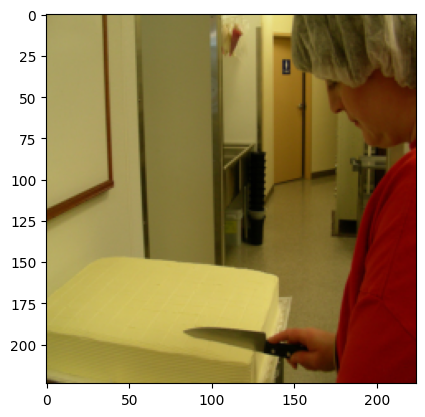

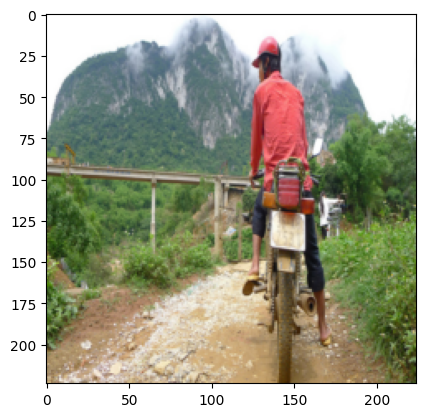

In [45]:
for caption in output:
    print(torch.argmax(caption, dim=-1))
    print(dataset.dataset.tokenizer.decode(torch.argmax(caption, dim=-1)))
for image in original_image:
    plt.imshow(image.permute(1, 2, 0).detach().cpu().numpy())
    plt.show()    

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


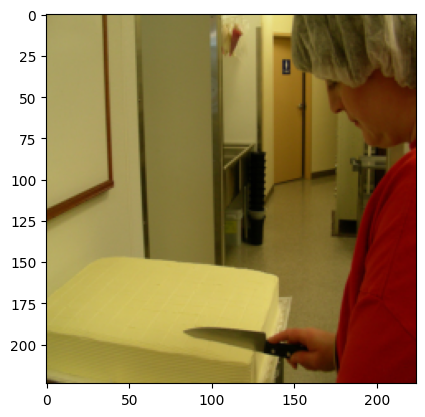

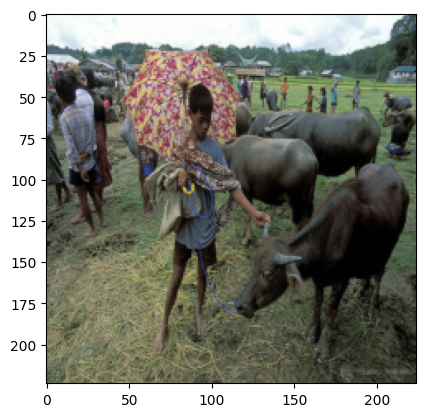

/Users/brandonzhou/opt/anaconda3/envs/dl_proj/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


cake
laptop
refurbished
lift
secession
##imating
奈
ap
tooth
##ssed
-------------
umbrella
young
boy
monitor
cake
computer
holding
penetration
exceptional
subscribers
-------------
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


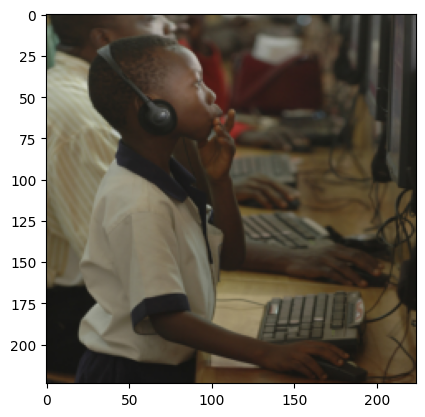

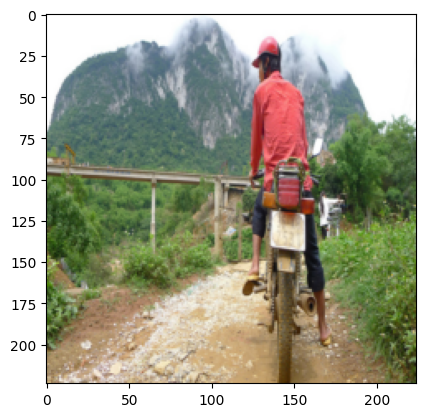

umbrella
young
boy
monitor
cake
computer
holding
blankly
penetration
subscribers
-------------
jean
##χ
statues
filtered
##mt
„
atlanta
smartphone
intruder
##ッ
-------------
Validation Loss: 0.000


In [53]:
model.eval() 
total_loss = 0.0

with torch.no_grad():
    for images, captions, lengths in dataloader:
        images = images.to(DEVICE, non_blocking=True)
        captions = captions.to(DEVICE, non_blocking=True)
        masked_images, masked_text, targets, (image_positions, rp) = noise_scheduler.get_masked(images, captions, lengths, need_masks=True)
        print(targets)
        for image in images:
            plt.imshow(image.permute(1, 2, 0).detach().cpu().numpy())
            plt.show() 
        reconstructed = model.forward(masked_images, lengths)
        for caption in reconstructed:
            values, indices = torch.topk(caption, 10)
            for i in indices:
                print(dataset.dataset.tokenizer.decode(i))
            print("-------------")        
        cap_loss = caption_loss(reconstructed, targets)
        total_loss += cap_loss.item() * images.size(0)

avg_loss = total_loss / len(dataset)
print(f"Validation Loss: {avg_loss:.3f}")
